In [5]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools
from multiprocessing import *
import warnings
warnings.filterwarnings("ignore")

""" LEGENDA
c: candidatos
d: disciplinas
i: individuos
p: preferências
"""

def adicionar_aluno(da:dict, d:str, a:int):
    if d in da:
        da[d].append(a)
    else:
        da[d] = [a]

def criar_individuo(d, da):
    """ 
    Os individuos são criados como se fossem a lista de disciplinas,
    sendo certo que cada valor é o nUSP do candidato. Caso a quantidade 
    de candidatos seja menor que a de disciplinas, serão preenchidos zeros
    até total de disciplinas.
    """
    i = []
    escolhidos = set()
    for alunos in d:
        a = set(da[alunos])
        a = list(a - escolhidos)
        if len(a) != 0:
            escolhido = random.choice(a)
            escolhidos.add(escolhido)
            i.append(escolhido)
        # Representa sala sem candidatos ou que os candidatos 
        # foram escolhidos para outras disciplinas
        else: 
            i.append(0)
    return i

def contar_salas(i, d, p):
    """ 
    Na evolução, os monitores podem ser designados para salas equivocadas.
    Por isso, precisamos checar se eles possuem formação na disciplina. A
    quantidade de salas reflete as designações corretas.
    """
    check = []
    for indice, valor in enumerate(i):
        if valor == 0: continue
        # dict_keys(['SME0341 - Álgebra Linear e Equações Diferenciais'])
        check.append(d[indice] in p[valor].keys())
    return sum(check)

def medir_satisfacao(i, d, p):
    """ 
    A satisfação do conjunto de monitores foi modelada utilizando uma 
    função exponencial, a qual atribui maior valor para preferência 1 
    e menor valor para a última disciplina. 
    """
    preferencias = []
    for indice, valor in enumerate(i):
        opcoes = p.get(valor, {})
        x = opcoes.get(d[indice], {})
        if valor == 0 or x == {}: 
            x = 0.0
        preferencias.append(np.exp(-0.4 * (x - 1)))
    return sum(preferencias)

def avaliar_individuo(i, d, p):
    """ 
    A avaliação do individuo é uma função de distância em relação à origem.
    Nesse caso, temos a quantidade de salas no eixo X e a satisfação do 
    conjunto de monitores no eixo y. Objetiva-se aumentar os valores em X e
    Y. Por isso, quanto maior o valor, melhor o resultado. Atribui-se peso
    na sala porque o quesito deve prevalecer sobre a satisfação dos monitores.
    """
    salas = len(i)*contar_salas(i, d, p)
    interesses = medir_satisfacao(i, d, p)
    return np.linalg.norm([salas, interesses]),

def do_the_scheduled(disciplinas, candidatos, preferencias, da, resultados):
    """ 
    Função paralelizada que recebe os dados de processamento e inicia um
    algoritmo genético para realizar uma busca heurística. A cada geração
    serão criados 2000 indivíduos e ao final serão preservados 10% da população
    mais adaptada (melhor avaliada). Em 20% dos indivíduos, haverá mutações aleatórias, 
    entendidas como embaralhamento dos elementos dos indivíduos (visando 
    explorar o espaço de busca).
    """
    tamanho_populacao = 1000
    n_geracoes = 200
    preservacao = 0.2

    creator.create('FitnessMax', base.Fitness, weights=(1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('individual', tools.initIterate, creator.Individual, lambda: criar_individuo(disciplinas, da))
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    toolbox.register('evaluate', lambda ind: avaliar_individuo(ind, disciplinas, preferencias))
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register('select', tools.selBest)

    pop = toolbox.population(n=tamanho_populacao)

    for _ in range(n_geracoes):
        for ind in pop:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        elitismo = int(preservacao * len(pop))
        elite = toolbox.select(pop, elitismo)

        offspring = toolbox.clone(pop)
        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        pop[:] = elite + offspring[:len(pop) - elitismo]

    resultados.put(tools.selBest(pop, 1)[0])


if __name__ == '__main__':

    processos = []
    resultados = Queue()
    df = pd.read_excel('Dados_monitores.xlsx')

    # Configurações iniciais
    """ 
    Disciplinas-Turmas: compostos das disciplinas e das turmas: string(<disciplina>-<turma>)
    Ex: ['Matemática-1','SCC0524 - Cálculo 496','Física-1', 'Química-1', 'Economia-2']
    """
    disciplinas = set()
    for x in (','.join(df.iloc[:, 3:7].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1).tolist())).split(','):
        disciplinas.add(x.strip()[3:])
    disciplinas = list(disciplinas)

    """ 
    Candidadtos: são representados pelo número USP do aluno.
    Ex: candidatos = [35543675, (...)]
    """
    candidatos = df.iloc[0:,0].tolist()
    
    """ 
    Preferências: foram selecionadas pela ordem de preferência e depois os dados foram na forma de uma
    função exponencial de modo a representar melhor os resultados finais. De qualquer forma, esse modelo 
    pode ser alterado para ser ponderado pela nota para diferenciar candidatos. Assim,
    o valor a ser colocado no lugar da preferência poderia ser um valor do interesse.

    preferencias = { int(<nUSP>) : { string(<TURMA-1>):float(<INTERESSE>) }}
    """
    preferencias = {}
    for row in df.itertuples():
        opcoes = {}
        for col in [4, 5, 6, 7]:
            if row[col] is not np.nan:
                for i in row[col].split(','):
                    opcoes[i.strip()[3:]] = row[9]
        preferencias[row[1]] = opcoes

    # Existem valores não numéricos nas notas. Precisam ser tratados.
    for n in preferencias:
        for d in preferencias[n]:
            if preferencias[n][d] == 'PÓS' or preferencias[n][d] == 'POS':
                preferencias[n][d] = 10.0

    # Foi necessário também criar um estrutura de dados que mostrasse o
    # relacionasse a disciplina (d) ao aluno (a) e, por isso, da.
    da = {}
    for d in disciplinas:
        for a in preferencias:
            if preferencias[a].get(d, {}) != {}: 
                adicionar_aluno(da, d, a)
    




    # Paralelizar para rodar n vezes
    for _ in range(cpu_count()):
        process = Process(target=do_the_scheduled, args=(disciplinas, candidatos, preferencias, da, resultados))
        process.start()
        processos.append(process)

    # Esperar executar a paralelização
    for process in processos:
        process.join()

    # Selecionar o melhor resultado obtido
    better = list()
    old_aval = 0
    while not resultados.empty():
        res = resultados.get()
        aval = avaliar_individuo(res, disciplinas, preferencias)
        if aval[0] > old_aval:
            old_aval = aval[0]
            better = res

    print('Melhor Indivíduo:', better)
    print('Quantas salas?',contar_salas(better, disciplinas, preferencias))
    print('Satisfação?', medir_satisfacao(better, disciplinas, preferencias))
    for index, nUSP in enumerate(better):
        if nUSP == 0:
            nUSP = 'Sem monitor'
            p = 'Sem preferência'
        else:
            p = preferencias.get(nUSP, {}).get(disciplinas[index], {})
        print(f'{disciplinas[index]} - nUSP: {nUSP} - Nota: {p} - Preferencia: {preferencias.get(nUSP, {})}')

Melhor Indivíduo: [14560051, 11780000, 13860019, 14580006, 11790072, 12680075, 12540029, 15500038, 14590001, 14140093, 94220069, 10270009, 14750091, 14570088, 11210018, 12540012, 14600054, 14560014, 12920042, 10310070, 11800021, 13690044, 12550013, 11910064, 12730002, 13830061, 11810057, 12540058, 12620030, 14550022, 14570008, 15110073, 12710059, 14560087, 14560015, 14650065, 90390040, 10690020, 10740003, 11840071, 12540096, 0, 10330084, 0, 15490086, 0, 13270062, 11910066, 13870027, 0, 13670092, 14590031, 11220090, 14710024, 14570078, 12550032, 13670035, 13680039, 14560079, 10740076, 55630067, 11220025, 13680080]
Quantas salas? 59
Satisfação? 15.303207005319173
SMA0355 - Cálculo III - nUSP: 14560051 - Nota: 6.7 - Preferencia: {'SLC0602 - Geometria Analítica': 6.7, 'SLC0608 - Cálculo II': 6.7, 'SMA0300 - Geometria Analítica': 6.7, 'SMA0304 - Álgebra Linear': 6.7, 'SMA0332 - Cálculo II': 6.7, 'SMA0353 - Cálculo I': 6.7, 'SMA0354 - Cálculo II': 6.7, 'SMA0355 - Cálculo III': 6.7, 'SMA0375 

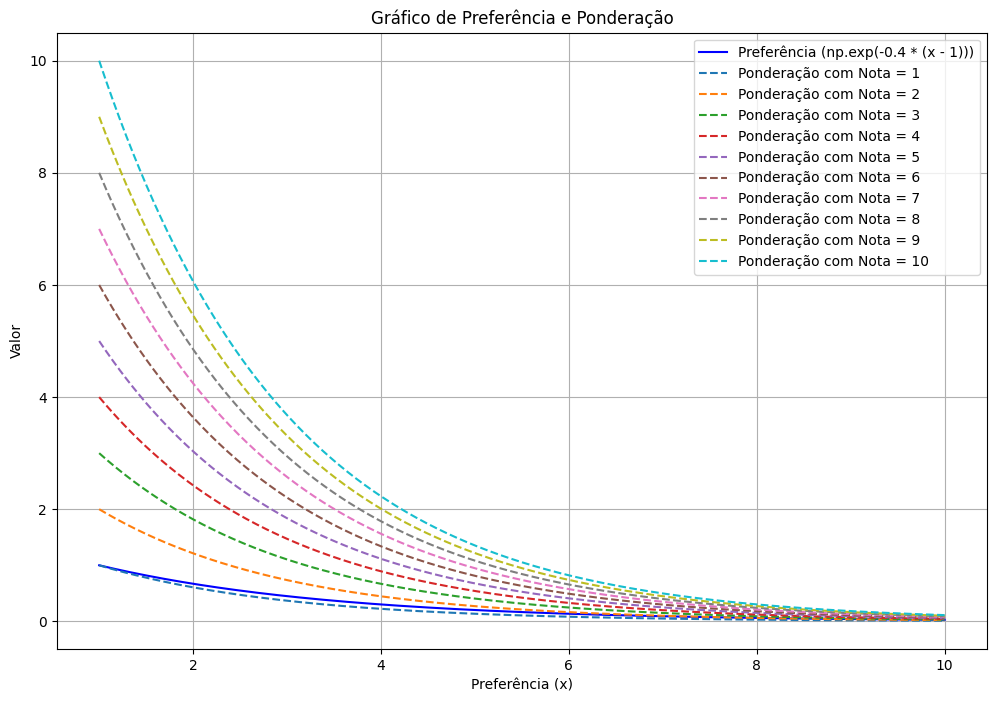

In [6]:
""" 
Análise da Ponderação do Interesse pela Nota
"""
import numpy as np
import matplotlib.pyplot as plt

# Definir o intervalo de valores de x (preferência)
x = np.linspace(1, 10, 500)

# Calcular a preferência usando a fórmula dada
preferencia = np.exp(-0.4 * (x - 1))

# Valores de ponderação de 1 a 10
notas = np.arange(1, 11)

# Calcular a ponderação para cada valor de nota
ponderacao = np.array([nota * np.exp(-0.5 * (x - 1)) for nota in notas])

# Criar o gráfico
plt.figure(figsize=(12, 8))

# Plotar a preferência
plt.plot(x, preferencia, label='Preferência (np.exp(-0.4 * (x - 1)))', color='blue')

# Plotar a ponderação para cada valor de nota
for i, nota in enumerate(notas):
    plt.plot(x, ponderacao[i], label=f'Ponderação com Nota = {nota}', linestyle='--')

# Adicionar títulos e rótulos
plt.title('Gráfico de Preferência e Ponderação')
plt.xlabel('Preferência (x)')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()
